In [1]:
import sys 
sys.path.append('../') 

In [2]:
import os
import shutil
import pandas as pd

from mibi_bin_tools import bin_files
from toffy import mph_comp
from ark.utils import io_utils

### Define file parameters
 * base_dir: this is the top-level directory to store the median pulse heights for different targets
 * bin_file_path: the directory containing your bin files
 * mph_dir: the directory to save the MPH visualizations to

In [3]:
# set up directories for current run
base_dir = os.path.join('..', 'toffy', 'data')
bin_file_path = os.path.join(base_dir, 'tissue')
mph_dir = os.path.join(base_dir, 'tissue_mph')
#mph_dir = os.path.join('C:\\Users\\Customer.ION\\Documents\\qc_metrics', 'tissue')

# make mph_dir if it doesn't exist
if not os.path.exists(mph_dir):
    os.makedirs(mph_dir)

In [4]:
# define which channel to retrieve data for
target = 'CD8'
mass_start = -0.3 
mass_stop = 0

# retrieve all the fov names from bin_file_path
fovs = io_utils.remove_file_extensions(io_utils.list_files(bin_file_path, substrs='.bin'))

# retrieve the total counts and compute pulse heights for each FOV run file
# saves individual .csv  files to bin_file_path
for fov in fovs:
    if not os.path.exists(os.path.join(bin_file_path, '%s-pulse_height.csv' % fov)):
        mph_comp.compute_mph_metrics(bin_file_path, fov, target, mass_start, mass_stop)

### Visualize MPH Plots

In [5]:
# prior to generating the graphs, need to combine the data for each FOV into one combined .csv
# saves directly to mph_dir
mph_comp.combine_mph_metrics(bin_file_path, mph_dir)

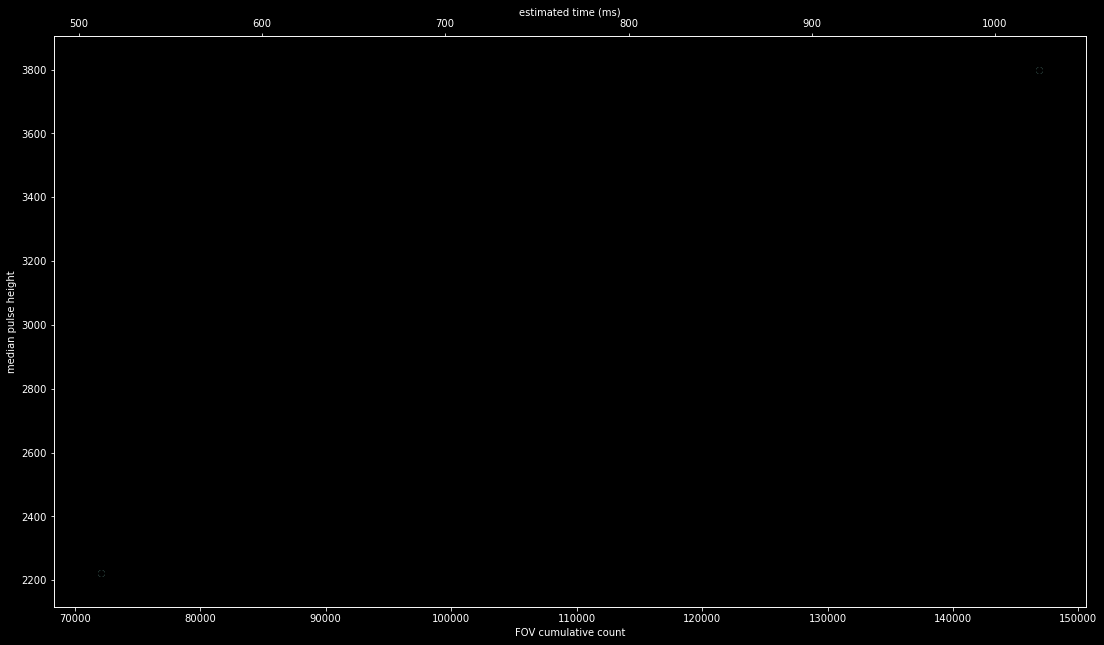

In [6]:
# visualize the median pulse heights
df_mph = pd.read_csv(os.path.join(mph_dir, 'total_count_vs_mph_data.csv'))
regression = False

mph_comp.visualize_mph(df_mph, regression, mph_dir)

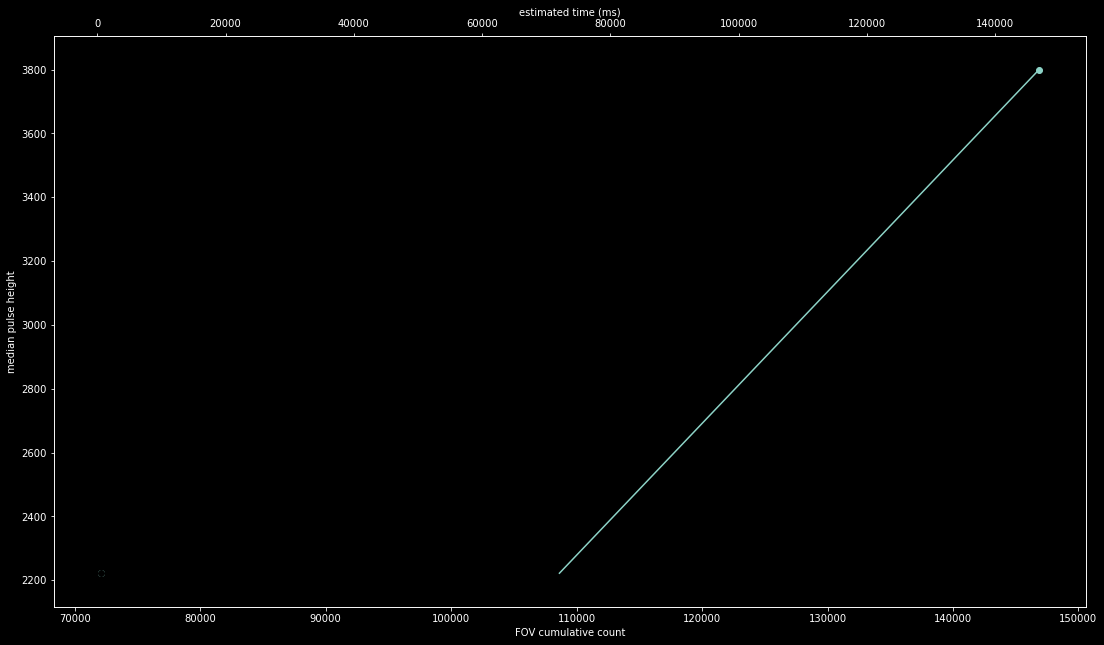

In [7]:
# plot with regression line
regression = True
mph_comp.visualize_mph(df_mph, regression, mph_dir)